In [1]:
import networkx as nx
import pickle
import wntr
import copy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
# matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 12})

In [40]:
# Load topologically critical nodes Dotwon_Nodes_upper_new
FTopological_critical = open(r'Dtown_Nodes_upper.pickle', 'rb')
Topological_critical = pickle.load(FTopological_critical)
FTopological_critical.close()

In [5]:
# Load hydraulicaaly critical nodes
FHydraulic_critical = open(r'Dtown_Nodes_hydraulic_critical.pickle', 'rb')
Hydraulic_critical = pickle.load(FHydraulic_critical)
FHydraulic_critical.close()

In [6]:
# Load the directed network
FDgraph = open(r'Dtown_Dgraph7am.pickle', 'rb')
Dgraph = pickle.load(FDgraph)
FDgraph.close()

In [34]:
# Load the leadnodes and downnodes in the cycles
'''
FCycle_leadnodes = open(r'Cycle_leadnodes_7am.pickle', 'rb')
Cycle_leadnodes = pickle.load(FCycle_leadnodes)
FCycle_leadnodes.close()
'''
FCycledownnodes = open(r'Cycle_downnodes_7am.pickle', 'rb')
Cycledownnodes = pickle.load(FCycledownnodes)
FCycledownnodes.close()


In [8]:
Wdn = wntr.network.WaterNetworkModel('D-town.inp') 

C:\Users\Zhouxiaomu\anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "D-town.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


### Get the critical nodes

In [41]:
Critical_nodes = list(set(Topological_critical + Hydraulic_critical))  

### Remove the nodes that in the downsteam of a cycle

In [35]:
Critical_nodesC = [node for node in Critical_nodes if node not in Cycledownnodes]

### Visualize the network and the critical nodes

In [10]:
def get_node_coordinate(wdn, node_list):
    node_x = []
    node_y = []
    for node in node_list:
        nodeobject = wdn.get_node(node)
        (x, y) = nodeobject.coordinates
        node_x.append(x)
        node_y.append(y)
    return node_x, node_y

In [11]:
def withdraw_coordinates(nodes, pos):
    nx = []
    ny = []
    for n in nodes:
        (x, y) = pos[n]
        nx.append(x)
        ny.append(y)
    return nx, ny

In [12]:
# The WTPs
WTPs = Wdn.reservoir_name_list
# For CoH
# WTPs = ['4027_1', '4027_2', '4027_3']
# GWTPs = ['3988', '3990', '3992', '3993', '3994', '3995', '3998', '3997', '3999', '4001', '4003', '4004', '4007', '4009', '4010', '4013', '4017', '4020', '4021', '4022', '4025']
W_x, W_y = get_node_coordinate(Wdn, WTPs)
#G_x, G_y = get_node_coordinate(Wdn, GWTPs)

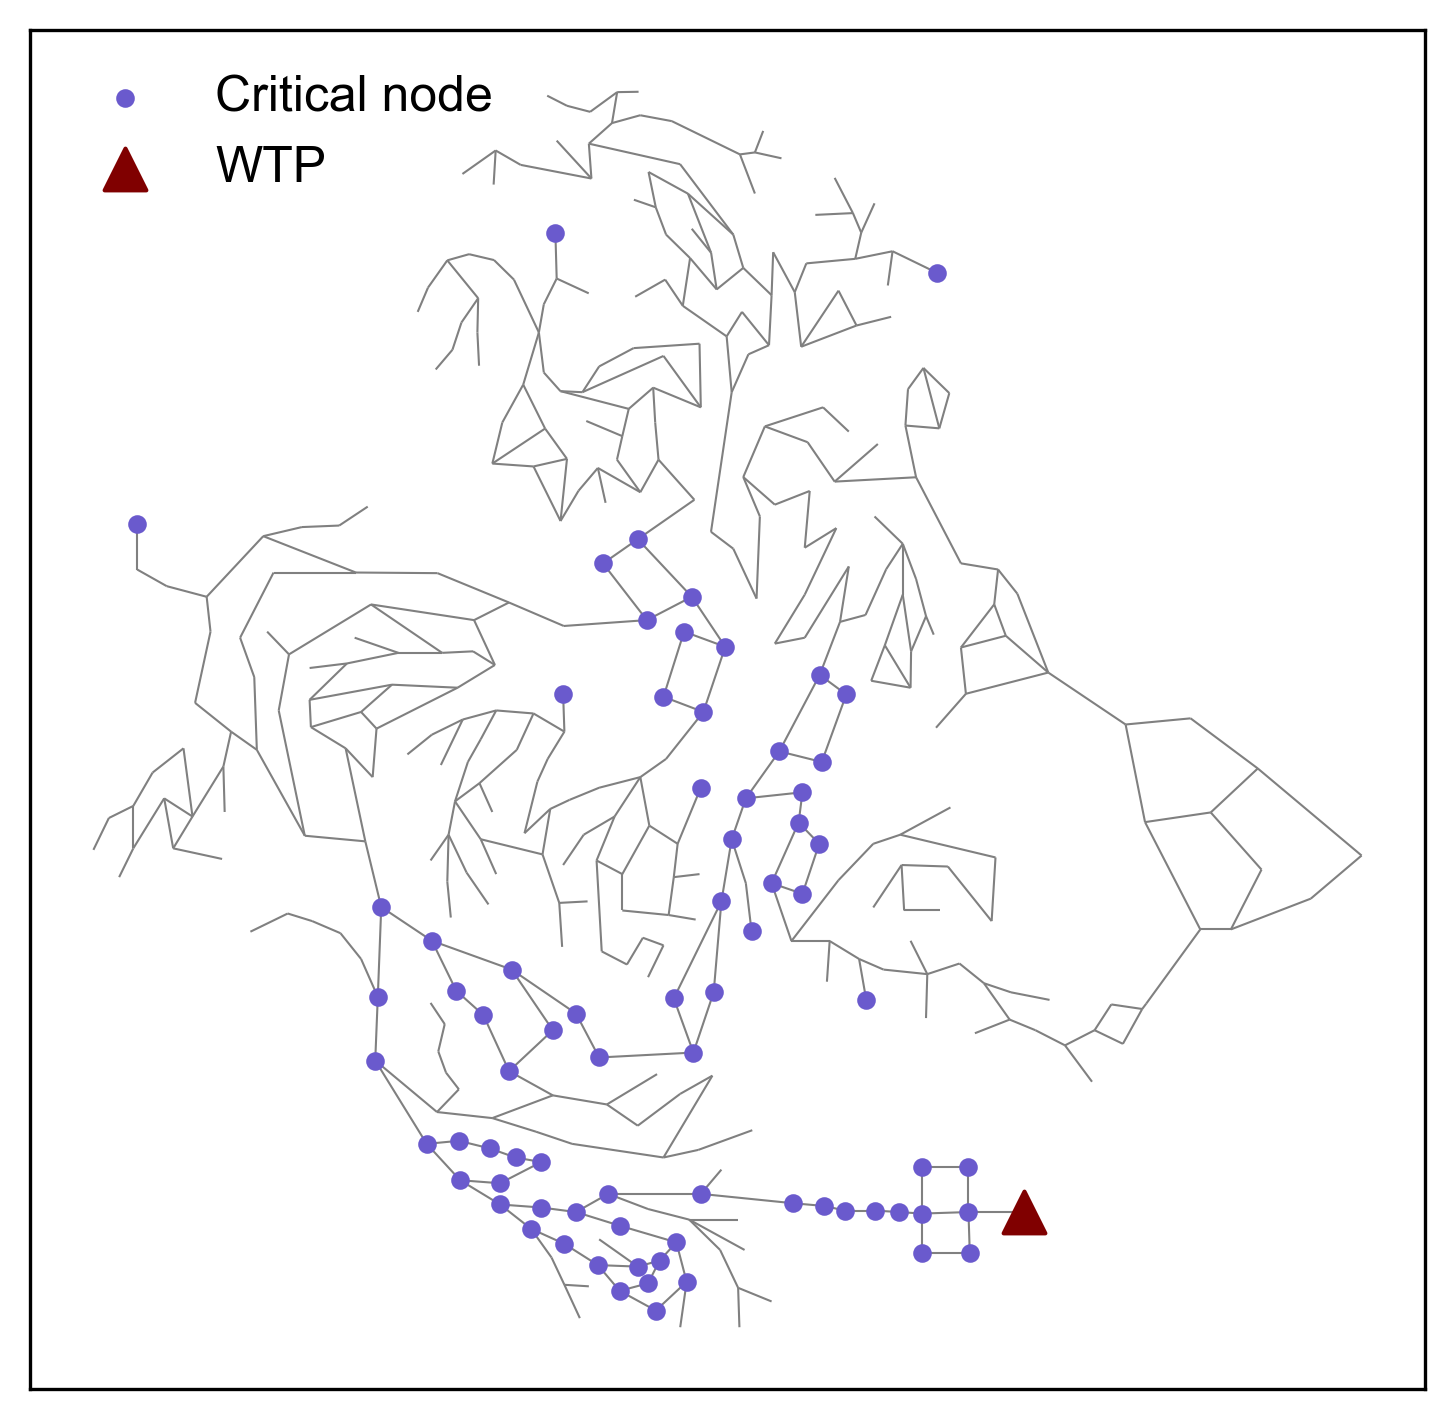

In [42]:
# Plot nodes
# Draw the whole network
G = Wdn.get_graph()
Pos = nx.get_node_attributes(G,'pos')
# Highlight the important nodes 
CX, CY = withdraw_coordinates(Critical_nodes, Pos)
nx.draw_networkx(G, pos = Pos, arrows=False, with_labels = False, width = 0.5, node_size = 0, edge_color = 'gray')
plt.scatter(CX, CY, s = 12, c = 'slateblue', label = 'Critical node')
plt.scatter(W_x, W_y, marker = "^", s = 100, c = 'maroon', label = 'WTP')
#plt.scatter(G_x, G_y, marker = "^", s = 60, c = 'darkorange', label = 'GWTP')
#plt.scatter(DPRPX, DPRPY, marker = "*", s = 60, c = 'seagreen', label = 'WWTP')
plt.legend(frameon=False, loc = 'upper left')
plt.xticks([])
plt.yticks([])
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
plt.savefig(r"Dtown_Critical_Nodes_new.jpg" , bbox_inches='tight')
plt.show()

### Extract the backbone nodes that are neceessary to connect the sources to critical nodes 

In [20]:
def retain_nodes(dgraph, critical_nodes, sourcenodes):
    # Get the pipes to retain to connect the drivernodes with sources '492', '4027_3', '505'
    retain = []
    for nodei in critical_nodes:
        # Check for each source
        for nodek in sourcenodes:
            try:
                if nx.has_path(dgraph, nodek, nodei):
                    # Path is the the one with shortest for rdgraph
                    path = nx.algorithms.shortest_paths.generic.shortest_path(dgraph, source=nodek, target=nodei)
                    retain += path
            except:
                pass
    # Make sure all the drivernodes are included, some with local sources
    retain += critical_nodes
    # Only store unique nodes
    retain = list(set(retain))
    return retain

In [22]:
Sourcenodes = WTPs
Nodes_retain = retain_nodes(Dgraph, Critical_nodes, Sourcenodes)

### Build the backbone network remove nodes and links that are not to be retained

In [23]:
def modifydgraph(dgraph, links_remove, nodes_retain):
    mdgraph = copy.deepcopy(dgraph)
    edgelist = list(mdgraph.edges)
    nodelist = list(mdgraph.nodes)
    for node in nodelist:
        if node not in nodes_retain:
            # The node may be removed already
            try:
                mdgraph.remove_node(node)
            except:
                pass
    # Get the maximum connected graph
    for edge in edgelist:
        # Get its linkid 
        (start_node, end_node) = edge
        linkid = dgraph[start_node][end_node]['linkid']
        if linkid in links_remove:
            try:
                mdgraph.remove_edge(start_node, end_node)
            except:
                pass
    mgraph = mdgraph.to_undirected()
    connected_component_subgraphs = (mgraph.subgraph(c) for c in nx.connected_components(mgraph))
    cg = max(connected_component_subgraphs, key=len) 
    return cg

In [29]:
# Load the links to retain


In [24]:
Links_remove = []
Backbone_network = modifydgraph(Dgraph, Links_remove, Nodes_retain)

In [26]:
FDtown_Backbone = open(r'Dtown_Backbone_network_7am.pickle', 'rb')
Dtown_Backbone = pickle.load(FDtown_Backbone)
FDtown_Backbone.close()

In [ ]:
Wdn = wntr.network.WaterNetworkModel(r'Dtown_Backbone_Final.inp')

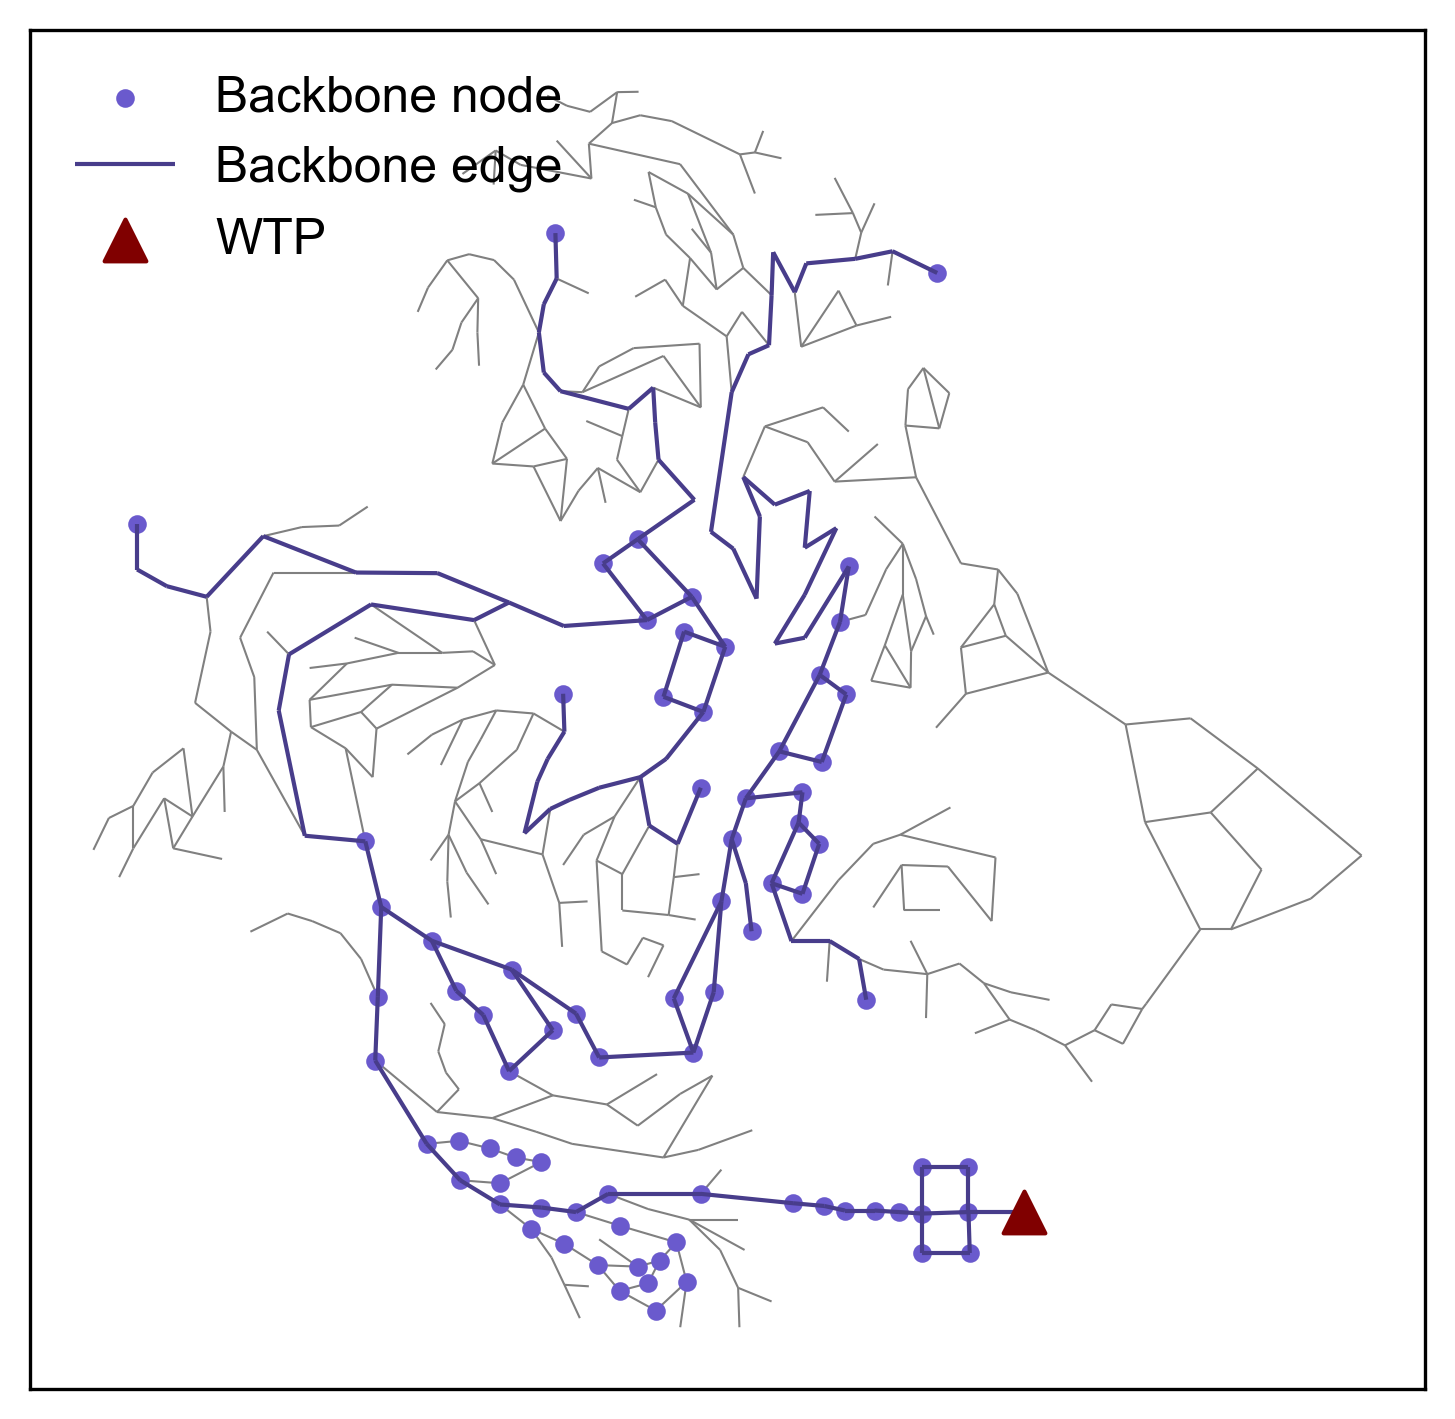

In [29]:
# Plot nodes
# Draw the whole network
G = Wdn.get_graph()
Pos = nx.get_node_attributes(G,'pos')
BPos = nx.get_node_attributes(Dtown_Backbone,'pos')
# Highlight the important nodes 
nx.draw_networkx(G, pos = Pos, arrows=False, with_labels = False, width = 0.5, node_size = 0, edge_color = 'gray')
# nx.draw_networkx(Dtown_Backbone, pos = BPos, arrows=False, with_labels = False, width = 1, node_color = 'slateblue', node_size = 12, edge_color = 'slateblue')
plt.scatter(CX, CY, s = 12, c = 'slateblue', label = 'Backbone node')
nx.draw_networkx_edges(Dtown_Backbone, pos = BPos, arrows = False, with_labels = False, width = 1, edge_color = 'darkslateblue', label = 'Backbone edge')
plt.scatter(W_x, W_y, marker = "^", s = 100, c = 'maroon', label = 'WTP')
# plt.scatter(G_x, G_y, marker = "^", s = 60, c = 'darkorange', label = 'GWTP')
#plt.scatter(DPRPX, DPRPY, marker = "*", s = 60, c = 'seagreen', label = 'WWTP')
plt.legend(frameon=False, loc = 'upper left')
plt.xticks([])
plt.yticks([])
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300
plt.savefig(r"Dtown_Backbone_Network_new.jpg" , bbox_inches='tight')
plt.show()

In [40]:
FBackbone_network = open(r'CoH_Backbone_network.pickle', 'wb')
pickle.dump(Backbone_network, FBackbone_network)
FBackbone_network.close()